In [5]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("./datasets/bike_data.csv", index_col=0)

In [6]:
# Copy this to other notebooks to get the train and test data
def load_train_test():
    train_df = pd.read_csv("./datasets/bike_train.csv", index_col=0)
    test_df = pd.read_csv("./datasets/bike_test.csv", index_col=0)
    X_train = train_df.drop("Count", axis=1).values
    y_train = train_df["Count"]
    X_test = test_df.drop("Count", axis=1).values
    y_test = test_df["Count"]
    return (X_train, X_test, y_train, y_test)

## Train Test Split

In [7]:
X_train, X_test, y_train, y_test = load_train_test()

## Random Forest Models

### Random Forest Basic


In [11]:
from sklearn.metrics import r2_score

def get_best_split(x, y, f_idxs):
    bfeature = None # best feature
    bthreshold = None # best threshold
    brss = float('inf') # best residual sum of squares
    for f in f_idxs: # go through each feature
        tholds = np.unique(x[:,f]) # get unique x-cutoff values (thresholds)
        tholds.sort()
        for t in tholds[1:]: # skip first, because we want a split of at least one sample
            yl_idx = x[:,f] < t # idx of those samples (of given feature) that are below threshold
            yl = y[yl_idx] # target region below threshold
            yr = y[~yl_idx] # target region above threshold
            lrss = ((yl - yl.mean())**2).sum() # region specific residual sum of squares (left)
            rrss = ((yr - yr.mean())**2).sum() # region specific residual sum of squares (right)
            trss = lrss + rrss # overall loss
            if trss < brss: # best split so far, record parameters
                brss = trss
                bthreshold = t
                bfeature = f
    return {'f': bfeature, 'thold': bthreshold} # tree node with best feature and x cutoff


def split(x, y, depth, max_features):
    if depth == 1 or len(x) < 2:
        return {'prediction': np.mean(y)}

    f_idxs = np.random.choice(x.shape[1], max_features, replace=False) # pick random features
    splitnode = get_best_split(x, y, f_idxs) # get the best split
    if splitnode['f'] == None or splitnode['thold'] == None: # if leaf node, return mean of remaining y values
        return {'prediction': np.mean(y)}
    left_ix = x[:,splitnode['f']] < splitnode['thold'] # x values below cutoff
    splitnode['left'] = split(x[left_ix], y[left_ix], depth-1, max_features)
    splitnode['right'] = split(x[~left_ix], y[~left_ix], depth-1, max_features)
    return splitnode

def predict_val(xval, rules):
    if 'prediction' in rules.keys():
        return rules['prediction'] # leaf node
    feature, thold = rules['f'], rules['thold']
    if xval[feature] < thold:
        return predict_val(xval, rules['left']) # search left tree
    else:
        return predict_val(xval, rules['right']) # search right tree

def _predict(samples, rules):
    return np.array([predict_val(sample, rules) for sample in samples]) #predict vector

class RegressionTree:
    def __init__(self, max_depth, max_features=None):
        self.max_depth = max_depth
        self.max_features = max_features
        self.rules = None

    def fit(self, x, y):
        self.rules = split(x, y, 0, self.max_depth)
        return self

    def predict(self, x):
        return _predict(x, self.rules)

    def evaluate(self, x, y):
        return r2_score(self.predict(x), y)

class RandomForest:
    def __init__(self, max_depth, max_features=None, n_trees=100, sample_sz=1.0):
        self.max_depth = max_depth
        self.n_trees = n_trees
        self.max_features = max_features
        self.sample_sz = sample_sz
        self.trees = []
        for i in range(self.n_trees):
            self.trees.append(RegressionTree(max_depth=self.max_depth, max_features=self.max_features))

    def fit(self, x, y):
        if isinstance(y, pd.Series):
            y = y.values
        for i in range(self.n_trees):
            sample_idx = np.random.choice(len(x), int(len(x)*self.sample_sz), replace=False)
            self.trees[i].fit(x[sample_idx], y[sample_idx])
        return self

    def predict(self, x):
        vals = np.zeros((self.n_trees, len(x)))
        for i in range(self.n_trees):
            vals[i] = self.trees[i].predict(x)
        return vals.mean(axis=0)

    def evaluate(self, x, y):
        return r2_score(self.predict(x), y)


LR = RandomForest(max_depth=13, max_features=13, sample_sz=0.40, n_trees=35)

reg = LR.fit(X_train,y_train)
y_pred = LR.predict(X_test)
print("R2 score for random forest: ", r2_score(y_test, y_pred))

R2 score for random forest:  0.9067246086627514


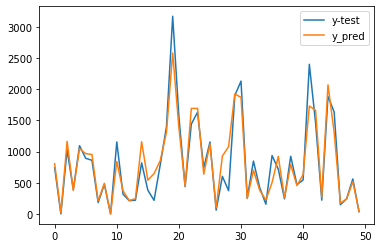

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
N = 50

plt.plot(list(y_test[:N]), label="y-test")
plt.plot(list(y_pred[:N]), label="y_pred")
plt.legend()
plt.show()

### Random Forest Variations


In [14]:
import numpy as np
from sklearn.model_selection import GridSearchCV

param_grid = {  
            'max_features': range(1,22, 4),
            'ccp_alpha': np.linspace(0, 0.04, 5)
} 
grid = GridSearchCV(RandomForestRegressor(), param_grid, verbose=3)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
print("R2 score for random forest (with grid search): ", r2_score(y_test, y_pred))

0, max_features=9 ...................................
[CV] ....... ccp_alpha=0.0, max_features=9, score=0.902, total=   1.2s
[CV] ccp_alpha=0.0, max_features=9 ...................................
[CV] ....... ccp_alpha=0.0, max_features=9, score=0.920, total=   1.2s
[CV] ccp_alpha=0.0, max_features=9 ...................................
[CV] ....... ccp_alpha=0.0, max_features=9, score=0.915, total=   1.2s
[CV] ccp_alpha=0.0, max_features=9 ...................................
[CV] ....... ccp_alpha=0.0, max_features=9, score=0.906, total=   1.2s
[CV] ccp_alpha=0.0, max_features=9 ...................................
[CV] ....... ccp_alpha=0.0, max_features=9, score=0.911, total=   1.2s
[CV] ccp_alpha=0.0, max_features=13 ..................................
[CV] ...... ccp_alpha=0.0, max_features=13, score=0.910, total=   1.5s
[CV] ccp_alpha=0.0, max_features=13 ..................................
[CV] ...... ccp_alpha=0.0, max_features=13, score=0.919, total=   1.5s
[CV] ccp_alpha=0.0, max

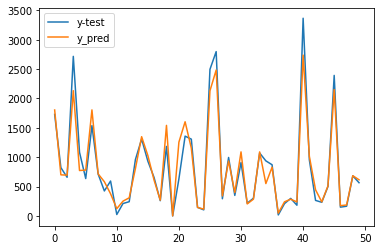

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
N = 50

plt.plot(list(y_test[:N]), label="y-test")
plt.plot(list(y_pred[:N]), label="y_pred")
plt.legend()
plt.show()

## Model Persistence

In [11]:
from joblib import dump, load
dump(LR, './models/random_forest.joblib') 

['./models/random_forest.joblib']